Importing Libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.patches as patches
import matplotlib.colors as mcolors 

In [46]:
class FilterSimulation():

    def setup(self, time_array, waveform, compression, num_samples, CONSTANT_PADDING):

        dense_time = np.linspace(0, time_array[-1], num_samples) # creates time axis from 0 to 1 with n samples
        dense_waveform = np.interp(dense_time, time_array / compression, waveform) # (x coordinates to evaluate values, compressed time array, waveform)

        original = np.pad(dense_waveform, pad_width=CONSTANT_PADDING, mode='edge')

        time_sliced = dense_time[:len(original)] #shorten time to match sliced IF longer than original
        dt = time_sliced[1] - time_sliced[0] # time difference between 2 samples -- for us this is 0.38
        time = np.arange(len(original)) * dt # constructs time array of original length with samples dt apart

        first_index = original[0]
        last_index = float(original[-1])

        return original, time, dt, first_index, last_index
    
    def filter(self):
        step_response = np.load('filter_data.npy')
        impulse_response = np.diff(step_response, prepend = 0)
        return impulse_response

    def convolution(self, waveform):
        impulse_response = self.filter()
        filtered_waveform = np.convolve(waveform, impulse_response, mode = 'full')
        return filtered_waveform
    
    def interpolation(self, time, shift, filtered):
        interp_func = interp1d(shift, filtered, kind='cubic', bounds_error=False, fill_value="extrapolate")
        filtered_interp = interp_func(time)  # Now same length as time_original
        return filtered_interp
    
    def plotter(self, original, time, filtered, precompensated_unfiltered, precompensated_filtered):
        plt.figure()
        plt.plot(time, original, label = 'Original')
        plt.plot(time, filtered, label = 'Filtered')
        plt.plot(time, precompensated_unfiltered, label = 'Precompensated Unfiltered', linestyle = '--')
        plt.plot(time, precompensated_filtered, label = 'Precompensated Filtered', linestyle = '--')
        plt.title('Lowpass-Filter Response')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def precompensation(self, waveform, last_index, reg_strength, CONSTANT_PADDING):
        impulse_response = self.filter()

        total_length = len(impulse_response) + len(waveform)
        ir_padded = np.pad(impulse_response, (CONSTANT_PADDING, total_length - len(impulse_response) - CONSTANT_PADDING), mode='constant')
        waveform_padded = np.pad(waveform, (CONSTANT_PADDING, total_length - len(waveform) - CONSTANT_PADDING), mode='constant', constant_values=last_index)

        G = fft(ir_padded)
        h_t = waveform_padded
        h_w = fft(h_t) #input waveform h(t)

        G_magnitude = np.abs(G) # amplitude attenuation
        G_phase = np.angle(G) # phase shift

        # Tikhonov regularization: prevents division by zeros or near-zeros
        regularized_magnitude = G_magnitude / (G_magnitude**2 + reg_strength) #does not al
        regularized_G = regularized_magnitude * np.exp(-1j * G_phase)

        f_w = h_w * regularized_G
        f_t = np.real(ifft(f_w))

        return f_t

    def trimming(self, precompensated, CONSTANT_PADDING, first_index, last_index):
        for i in range(0, int(CONSTANT_PADDING*0.3)):
            precompensated[i] = first_index      
        for i in range(len(precompensated) - int(CONSTANT_PADDING*0.5), len(precompensated)):
            precompensated[i] = last_index
        return precompensated

Original Voltage Ramp

In [ ]:
compression = 1 # manual value
num_samples = 2020 # manual value
CONSTANT_PADDING = 300 # manual value
reg_strength = 5e-4

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array, waveform, compression, num_samples, CONSTANT_PADDING)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index, reg_strength)
precompensated = FilterSimulation().trimming(precompensated, CONSTANT_PADDING, first_index, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# Scale to correct values:
time *= 17.5        
original *= -6   
filtered *= -6
precompensated_unfiltered *= -6
precompensated_filtered *= -6

FilterSimulation().error_estimator(time, original, precompensated_filtered)
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)

Lower Bounds of the Simulation (Voltage hits -40 volts)

Optimize the Results (min padding; min error; max compression; best regularization)

In [95]:
class Optimize:
        
    def __init__(self):
        self.padding_range = list(range(60, 80))  #20, 101 <-- For first 2; 50, 80 <-- For last 1
        self.reg_exponents = list(range(-5, 0))   
        self.compression_range = list(range(1, 2)) #20, 50 <-- For first 2; 3, 5 <-- For last 1
        self.lower_voltage_bound = -40
        self.upper_voltage_bound = 40

        self.alpha = 3.00 # <-- weight of rmse (MUST be stronger) (default: 1.00)
        self.beta = 0.001 # <-- weight of padding (default: 0.01)
        self.gamma = 0.001 # <-- weight of compression (default: 0.01)

    def optimizer(self, waveform, time_array, num_samples):
        best_penalty = float('inf')
        best_params = (None, None, None, None, None) # compression, padding, reg_strength, penalty, bounds
        all_best_params = []

        error_grid = np.full((len(self.padding_range), len(self.reg_exponents)), np.nan)
        bounds_grid = np.full((len(self.padding_range), len(self.reg_exponents)), np.nan)  # NEW

        # generate all possibilities:
        for k, compress in enumerate(self.compression_range):
            for i, padding in enumerate(self.padding_range):
                for j, reg in enumerate(self.reg_exponents):
                    reg_strength = 10 ** reg
                    
                    dense_time = np.linspace(0, time_array[-1], num_samples) # creates time axis from 0 to 1 with n samples
                    dense_waveform = np.interp(dense_time, time_array / compress, waveform) # (x coordinates to evaluate values, compressed time array, waveform)
                    original = np.pad(dense_waveform, pad_width=padding, mode='edge')
                    time_sliced = dense_time[:len(original)] #shorten time to match sliced IF longer than original
                    dt = time_sliced[1] - time_sliced[0] # time difference between 2 samples -- for us this is 0.38
                    time = np.arange(len(original)) * dt # constructs time array of original length with samples dt apart
                    first_index = original[0]
                    last_index = float(original[-1])

                    precompensated = FilterSimulation().precompensation(original, last_index, reg_strength, padding)
                    precompensated = precompensated[:len(original)]
                    precompensated = FilterSimulation().trimming(precompensated, padding, first_index, last_index)
                    precompensated_filtered = FilterSimulation().convolution(precompensated)
                    shift_p = np.arange(len(precompensated_filtered)) * dt
                    precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)
                    
                    rmse = np.sqrt(mean_squared_error(original, precompensated_filtered))
                    error_grid[i, j] = rmse
                    penalty = self.alpha * rmse + self.beta * padding - self.gamma * compress
                    bounds = 1 if np.max(precompensated) > self.upper_voltage_bound or np.min(precompensated) < self.lower_voltage_bound else 0
                    bounds_grid[i, j] = bounds

                    best_params = (compress, padding, reg_strength, penalty, bounds)
                    all_best_params.append(best_params)
                    best_error_grid = error_grid.copy()
                    
        valid_results = [res for res in all_best_params if res[4] == 0]
        if not valid_results:
            print("No valid results found within bounds! Returning least-penalty violating case.")
            best_params = min(all_best_params, key=lambda x: x[3])
        else:
            best_params = min(valid_results, key=lambda x: x[3])

        return best_error_grid, bounds_grid, best_params[0], best_params[1], best_params[2]

    def heatmap(self, error_grid, bounds_grid, best_padding, best_reg_strength, best_compression):
        plt.figure(figsize=(10, 8))
        
        cmap = sns.color_palette("coolwarm", as_cmap=True)
        ax = sns.heatmap(
            error_grid,
            xticklabels=[f'1e{exp}' for exp in self.reg_exponents],  # regularization strengths
            yticklabels=self.padding_range[::10],  # compression values
            cmap=cmap,
            cbar_kws={'label': 'RMSE Error (in V)'},
            annot=False, # set to true for values displayed on each cell
            fmt='.2e' # scientific notation format for annotations
        )

        # gray overlay where bounds = 1:
        overlay = np.where(bounds_grid == 1, 1, np.nan)  # 1 where out of bounds, NaN elsewhere
        sns.heatmap(
            overlay,
            mask=np.isnan(overlay),
            cmap=mcolors.ListedColormap([(0.5, 0.5, 0.5, 0.8)]),  # Gray with alpha=0.8
            cbar=False,
            ax=ax
        )

        plt.title(f'Heatmap at Compression x{best_compression}')
        plt.xlabel('Regularization Strength')
        plt.ylabel('Padding Samples')
        n_yticks = 10
        ytick_positions = np.linspace(0, len(self.padding_range)-1, n_yticks, dtype=int)
        plt.yticks(ytick_positions, [self.padding_range[i] for i in ytick_positions])
        plt.xticks(rotation=45)
        ax.grid(False)
        rect = patches.Rectangle((self.reg_exponents.index(int(np.log10(best_reg_strength))), self.padding_range.index(best_padding)), 1, 1, fill=False, edgecolor='gold', lw=3)
        ax.add_patch(rect)
        plt.tight_layout()
        plt.show()

    def error_plotter(self, time, original, precompensated_filtered, best_padding, best_reg_strength):
        rmse = np.sqrt(mean_squared_error(original, precompensated_filtered)) # average error across all points (precompensation is off by about -- volts)
        pointwise_error = np.abs(original - precompensated_filtered) # worst deviation point in the waveform 
        print(f'The best padding is:', best_padding)
        print(f'The best regularization is:', best_reg_strength)
        print(f"Root Mean Squared Error (RMSE): {rmse:.5f} V")
        print(f"Max Absolute Error: {np.max(pointwise_error):.5f} V")

        # absolute error over time:
        plt.plot(time, pointwise_error, color='red', label='|Original - Precompensated Filtered|')
        plt.title('Error between Original and Precompensated Filtered Signal')
        plt.xlabel('Time in µs')
        plt.ylabel('Absolute Error (V)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

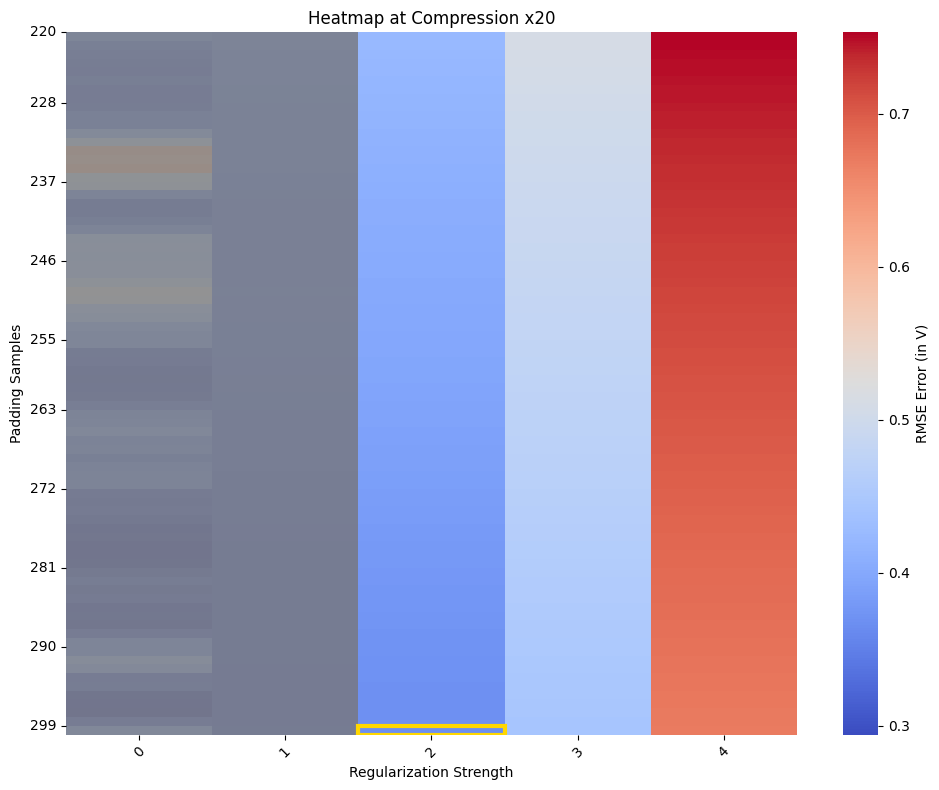

The best padding is: 299
The best regularization is: 0.001
Root Mean Squared Error (RMSE): 0.34712 V
Max Absolute Error: 2.74936 V


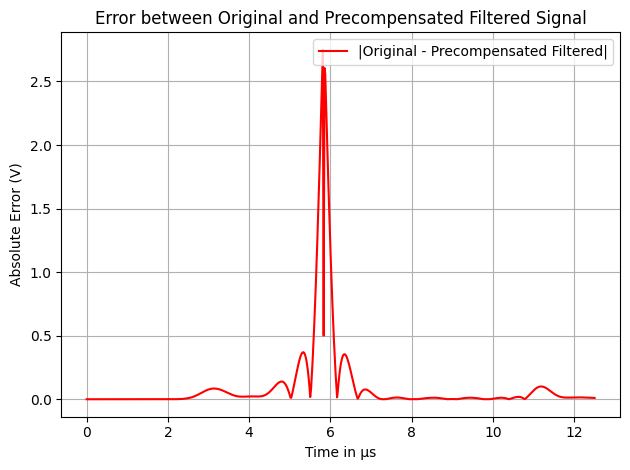

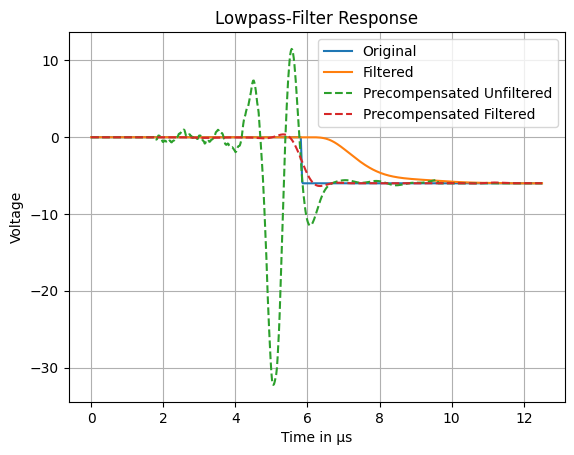

In [84]:
#input values:
waveform_size = -6 #volts
total_time = 17.5 # y-scale amount
time_step = 0.38 # DAQ lower limit
lower_voltage_bound = -40 # volts
upper_voltage_bound = 40 # volts
#########################################
num_samples = int(total_time / time_step)

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1

time_array *= total_time
waveform *= waveform_size

best_error_grid, bounds_grid, best_compression, best_padding, best_reg_strength = Optimize().optimizer(waveform, time_array, num_samples)
Optimize().heatmap(best_error_grid, bounds_grid, best_padding, best_reg_strength, best_compression)
#Optimize().compression_vs_rmse(waveform, time_array / best_compression, num_samples)

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array / best_compression, waveform, best_compression, num_samples, best_padding)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index, best_reg_strength, best_padding)
precompensated= precompensated[:len(original)]
precompensated = FilterSimulation().trimming(precompensated, best_padding, first_index, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

Optimize().error_plotter(time, original, precompensated_filtered, best_padding, best_reg_strength) # <-- error checker
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)

Lower Bounds of the Simulation (Voltage hits +40 volts)

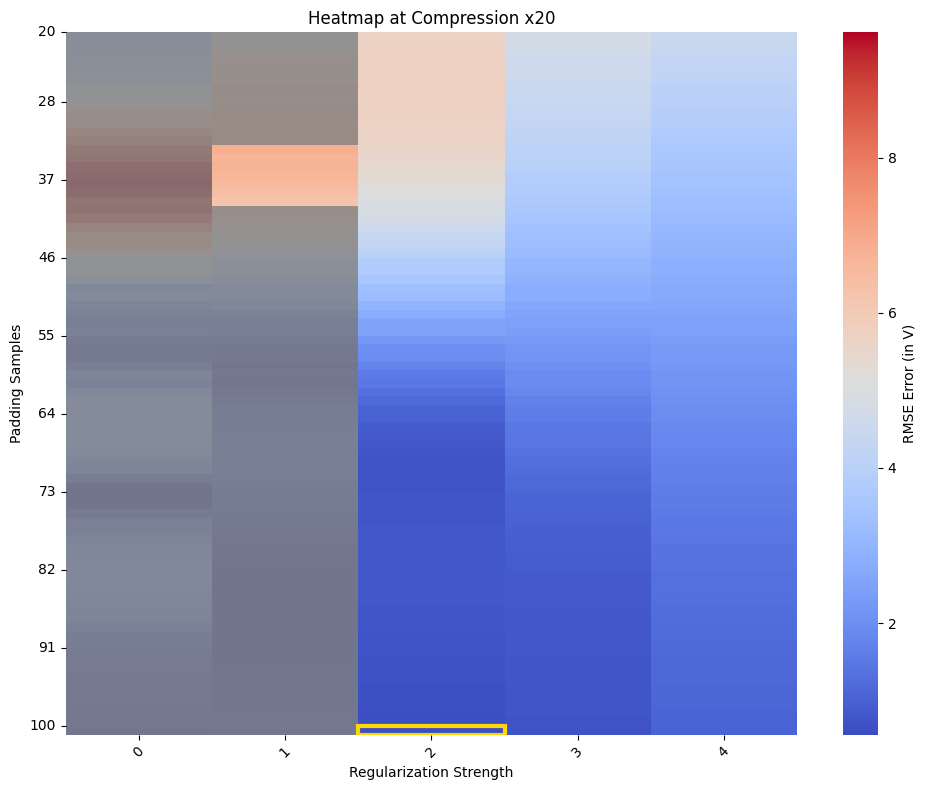

The best padding is: 100
The best regularization is: 0.001
Root Mean Squared Error (RMSE): 0.57688 V
Max Absolute Error: 2.94880 V


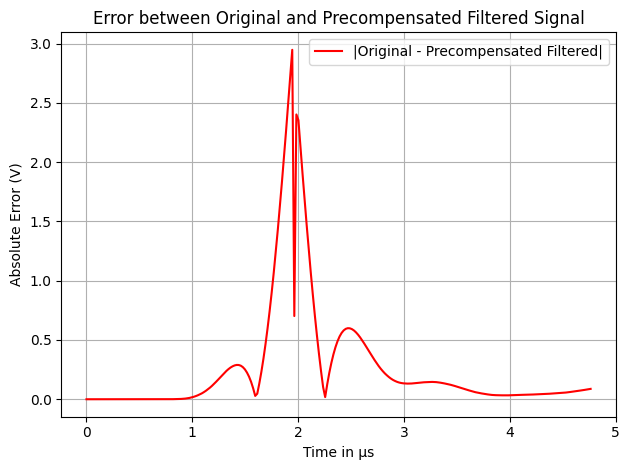

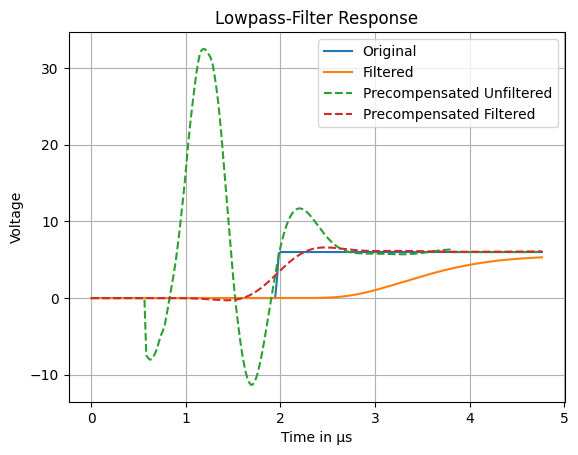

In [82]:
#input values:
waveform_size = -6 #volts
total_time = 17.5 # y-scale amount
time_step = 0.38 # DAQ lower limit
lower_voltage_bound = -40 # volts
upper_voltage_bound = 40 # volts
#########################################
num_samples = int(total_time / time_step)

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform = np.array([0, -0.0009866358, -0.0039426493, -0.0088563746, -0.0157084194, -0.0244717419, -0.0351117571, -0.0475864738, -0.06184666, -0.0778360372, -0.0954915028, -0.1147433786, -0.1355156863, -0.157726447, -0.1812880051, -0.2061073739, -0.2320866025, -0.2591231629, -0.2871103542, -0.3159377237, -0.3454915028, -0.3756550564, -0.4063093427, -0.4373333832, -0.4686047402, -0.5, -0.5313952598, -0.5626666168, -0.5936906573, -0.6243449436, -0.6545084972, -0.6840622763, -0.7128896458, -0.7408768371, -0.7679133975, -0.7938926261, -0.8187119949, -0.842273553, -0.8644843137, -0.8852566214, -0.9045084972, -0.9221639628, -0.93815334, -0.9524135262, -0.9648882429, -0.9755282581, -0.9842915806, -0.9911436254, -0.9960573507, -0.9990133642, -1])

time_array *= total_time
waveform *= waveform_size

best_error_grid, bounds_grid, best_compression, best_padding, best_reg_strength = Optimize().optimizer(waveform, time_array, num_samples)
Optimize().heatmap(best_error_grid, bounds_grid, best_padding, best_reg_strength, best_compression)
#Optimize().compression_vs_rmse(waveform, time_array / best_compression, num_samples)

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array / best_compression, waveform, best_compression, num_samples, best_padding)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index, best_reg_strength, best_padding)
precompensated= precompensated[:len(original)]
precompensated = FilterSimulation().trimming(precompensated, best_padding, first_index, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

Optimize().error_plotter(time, original, precompensated_filtered, best_padding, best_reg_strength) # <-- error checker
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)

Multiple Segment Transport Lower Bounds of the Simulation (Voltage hits -40 volts)

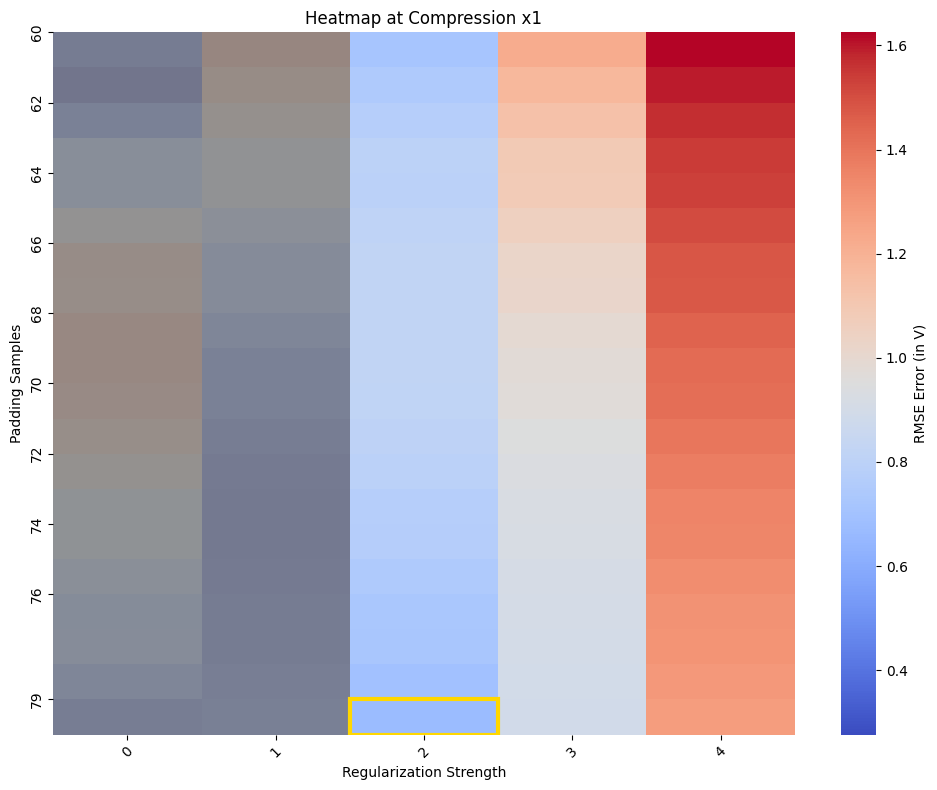

The best padding is: 79
The best regularization is: 0.001
Root Mean Squared Error (RMSE): 0.67114 V
Max Absolute Error: 2.04834 V


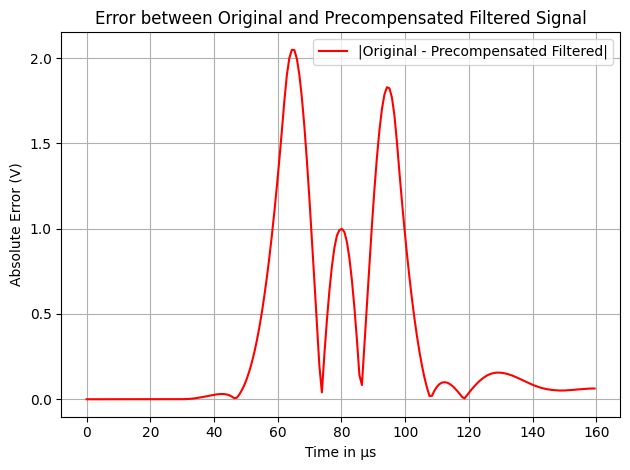

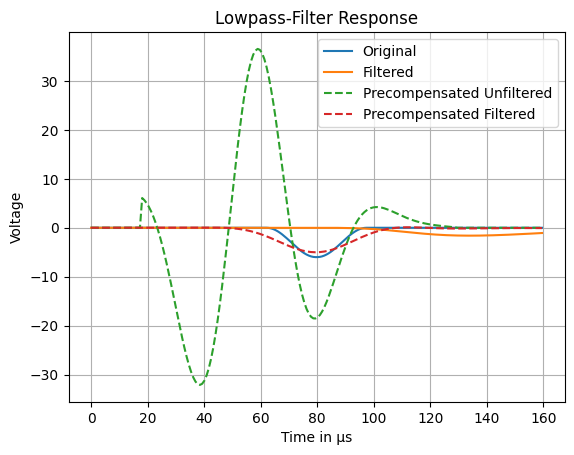

In [96]:
#input values:
waveform_size = -6 #volts
total_time = 17.5 # y-scale amount
time_step = 0.38 # DAQ lower limit
lower_voltage_bound = -40 # volts
upper_voltage_bound = 40 # volts
#########################################
num_samples = int(total_time / time_step)

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform_1 = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1
waveform_2 = np.array([0, -0.0009866358, -0.0039426493, -0.0088563746, -0.0157084194, -0.0244717419, -0.0351117571, -0.0475864738, -0.06184666, -0.0778360372, -0.0954915028, -0.1147433786, -0.1355156863, -0.157726447, -0.1812880051, -0.2061073739, -0.2320866025, -0.2591231629, -0.2871103542, -0.3159377237, -0.3454915028, -0.3756550564, -0.4063093427, -0.4373333832, -0.4686047402, -0.5, -0.5313952598, -0.5626666168, -0.5936906573, -0.6243449436, -0.6545084972, -0.6840622763, -0.7128896458, -0.7408768371, -0.7679133975, -0.7938926261, -0.8187119949, -0.842273553, -0.8644843137, -0.8852566214, -0.9045084972, -0.9221639628, -0.93815334, -0.9524135262, -0.9648882429, -0.9755282581, -0.9842915806, -0.9911436254, -0.9960573507, -0.9990133642, -1]) + 1

waveform = np.concatenate((waveform_1, waveform_2)) #modify this to concatenate multiple waveforms
new_time_array = time_array + time_array[-1] + time_array[1] - time_array[0]
time_array = np.concatenate((time_array, new_time_array))

time_array *= total_time
waveform *= waveform_size

best_error_grid, bounds_grid, best_compression, best_padding, best_reg_strength = Optimize().optimizer(waveform, time_array, num_samples)
Optimize().heatmap(best_error_grid, bounds_grid, best_padding, best_reg_strength, best_compression)
#Optimize().compression_vs_rmse(waveform, time_array / best_compression, num_samples)

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array / best_compression, waveform, best_compression, num_samples, best_padding)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index, best_reg_strength, best_padding)
precompensated= precompensated[:len(original)]
precompensated = FilterSimulation().trimming(precompensated, best_padding, first_index, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

Optimize().error_plotter(time, original, precompensated_filtered, best_padding, best_reg_strength) # <-- error checker
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)